In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install patchify
!pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.5 MB/s eta 0:00:00


In [1]:
%env SM_FRAMEWORK=tf.keras
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tqdm import tqdm
import random
import pickle
from tensorflow.keras.callbacks import Callback, ModelCheckpoint,  EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [2]:
sm.set_framework('tf.keras')  

In [3]:
loaded_image_dataset = np.load('/content/drive/MyDrive/image_dataset.npy')
loaded_labels_dataset = np.load('/content/drive/MyDrive/labels_dataset.npy')

Unique labels in label dataset are:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


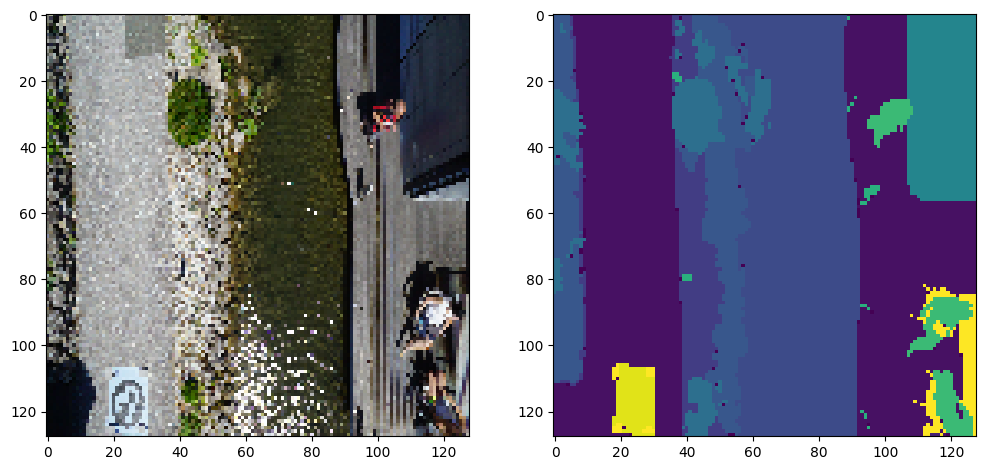

In [73]:
print("Unique labels in label dataset are: ", np.unique(loaded_labels_dataset))

#Another Sanity check...
image_number = random.randint(0, len(loaded_labels_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(loaded_image_dataset[image_number])
plt.subplot(122)
plt.imshow(loaded_labels_dataset[image_number][:,:,0])
plt.show()

In [5]:
n_classes = 23 # 23 classes...
labels_cat = to_categorical(loaded_labels_dataset, num_classes=n_classes)# one hot encoding the labels...

In [45]:
X_train, X_test, y_train, y_test = train_test_split(loaded_image_dataset, labels_cat, test_size = 0.20) # train test split for data...

In [46]:
BACKBONE = 'resnet34' 
preprocess_input = sm.get_preprocessing(BACKBONE)
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

In [8]:
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax' )
metrics=['accuracy']
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [11]:
model_resnet_backbone.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [47]:
# ModelCheckpoint callback is used to save only the best model out of all the epochs...
checkpoint = ModelCheckpoint(filepath="../models/patched_resnet_backbone.h5", verbose=2, save_best_only=True)

# EarlyStopping callback is used to stop the training when accuracy doesn't improve for 5 epochs...
early_stop = EarlyStopping(monitor="accuracy", min_delta=0, patience=10)

callbacks = [checkpoint, early_stop]

In [48]:
history1 = model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=23, 
          epochs=100,
          callbacks=callbacks,
          verbose=1,
          validation_data=(X_test_prepr, y_test))

Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 0.3380 - accuracy: 0.9130
Epoch 1: val_loss improved from inf to 1.15188, saving model to ../models/patched_resnet_backbone.h5
14/14 [==============================] - 5s 330ms/step - loss: 0.3380 - accuracy: 0.9130 - val_loss: 1.1519 - val_accuracy: 0.8276
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 0.3697 - accuracy: 0.8870
Epoch 2: val_loss did not improve from 1.15188
14/14 [==============================] - 2s 155ms/step - loss: 0.3697 - accuracy: 0.8870 - val_loss: 1.9129 - val_accuracy: 0.6769
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 0.4187 - accuracy: 0.8742
Epoch 3: val_loss did not improve from 1.15188
14/14 [==============================] - 2s 146ms/step - loss: 0.4187 - accuracy: 0.8742 - val_loss: 6.7985 - val_accuracy: 0.5783
Epoch 4/100
14/14 [==============================] - ETA: 0s - loss: 0.5656 - accuracy: 0.8322
Epoch 4: val_loss did not improv

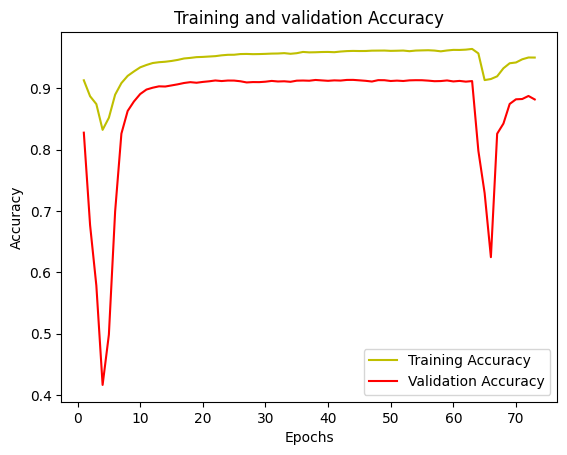

In [65]:
# plotting train and val accuracy in each epoch...
history = history1
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

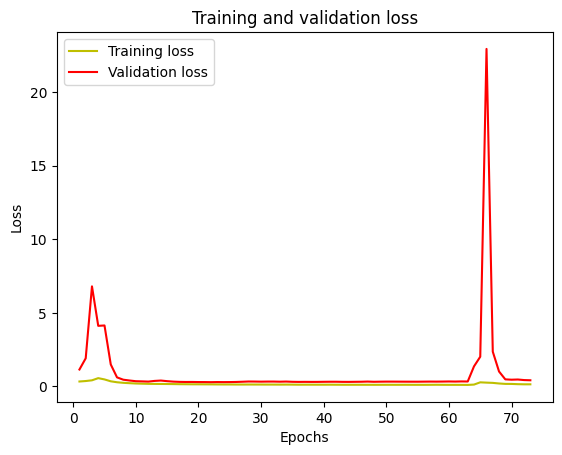

In [74]:
accuracy = history.history['loss']
val_accuracy = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training loss')
plt.plot(epochs, val_accuracy, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
patched_model = load_model('../models/patched_resnet_backbone.h5') # loading model...

In [51]:
# making predictions...
y_pred=patched_model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

3/3 [==============================] - 1s 56ms/step


1/1 [==============================] - 0s 39ms/step


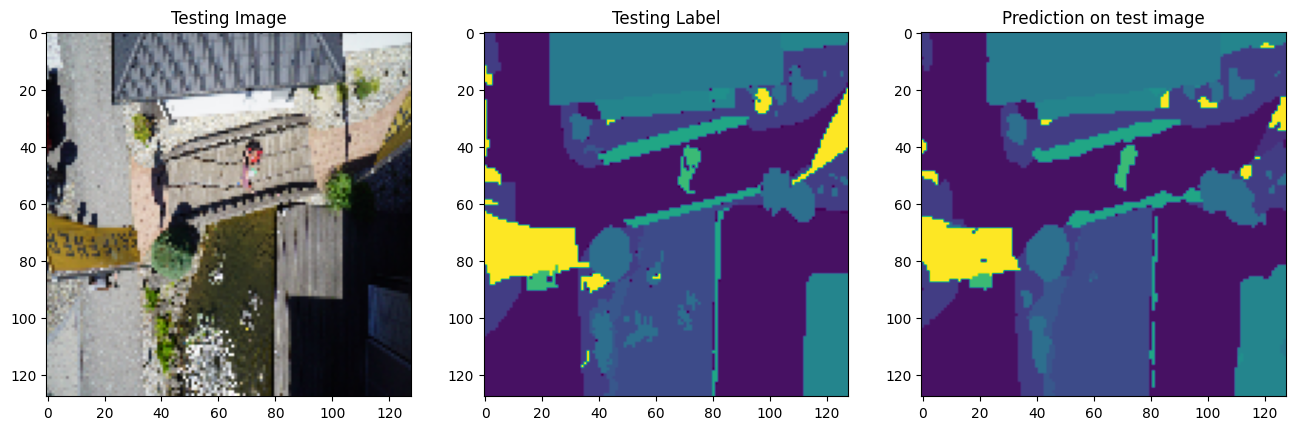

In [58]:
# randomly selecting an image from the test set and making prediction...
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (patched_model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

# plotting the real image, test labeled image and predicted labeled image...
plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()